In [79]:
#all packages and dataframes
import numpy as np
import results
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ptitprince as pt
%matplotlib inline
# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/results/ridge/acc/'
subDir=thisDir+'output/subNetwork/'
randDir=thisDir+'output/randomIdx/'
netList=['default', 'visual','fp','dan','van','salience','co','sm','auditory','pmn','pon']
feature=[10824,8736, 4620,5264,3151, 484, 4060, 2375, 564,45,21]
netRoi=dict([('default', 10824),('visual',8736),('fp', 4620),('dan',5264),('van',3151),('salience', 484),('co', 4060),('sm', 2375),('sm-lat', 316),('auditory', 564),('pmn',45),('pon',21)])
sns.set_style("white")
sns.set_context("talk")



#same task folds dataframes
DS_violin=pd.read_csv(outDir+'DS/folds/allFolds.csv')
DS_violin['Analysis']='Diff Sub'
CV=pd.read_csv(outDir+'CV/reformedFolds.csv')
CV.drop(columns='sub', inplace=True)
CV['Analysis']='Same Sub'
frames=[DS_violin, CV]
sameTask=pd.concat(frames)

#plotACC of heatmaps for DS analysis
DS_heat=pd.read_csv(outDir+'DS/acc.csv', usecols=[1,2,3,4])

#different task analysis comparison does not require opening dataframe

#all statistics related tables will be computes in a separate script

#raincloud plot dataframes
#SS
SS=pd.read_csv(outDir+'SS/folds/allFolds.csv')
SS.drop(columns='test', inplace=True)
#reformate to get in long form
SS=SS.pivot_table(index = ['train',
                        SS.groupby(['train','sub']).cumcount()],
               columns = 'sub',
               values = 'acc')

SS.reset_index(inplace=True)
SS.drop(columns='level_1',inplace=True)


#subnetworks overlapped with random network sampling
SS_nets=pd.DataFrame()
DS_nets=pd.DataFrame()
CV_nets=pd.DataFrame()
BS_nets=pd.DataFrame()
for i in netList:
    tmpSS=pd.read_csv(subDir+i+'/results/Ridge/acc/SS/acc.csv')
    #tmpSS['Analysis']='ridge'
    tmpSS['Network']=i
    tmpSS['Features']=netRoi[i]
    SS_nets=pd.concat([SS_nets,tmpSS])
    
    tmpDS=pd.read_csv(subDir+i+'/results/Ridge/acc/DS/acc.csv')
    tmpDS['Network']=i
    tmpDS['Features']=netRoi[i]
    DS_nets=pd.concat([DS_nets,tmpDS])
    
    tmpBS=pd.read_csv(subDir+i+'/results/Ridge/acc/BS/acc.csv')
    tmpBS['Network']=i
    tmpBS['Features']=netRoi[i]
    BS_nets=pd.concat([BS_nets,tmpBS])
    
    tmpCV=pd.read_csv(subDir+i+'/results/Ridge/acc/CV/acc.csv')
    tmpCV=tmpCV.melt(id_vars='sub', value_vars=['mixed', 'motor','mem'], var_name='Task', value_name='Accuracy')
    tmpCV['Network']=i
    tmpCV['Features']=netRoi[i]
    CV_nets=pd.concat([CV_nets,tmpCV])
    
    
SS_nets.drop(columns='Unnamed: 0', inplace=True)
DS_nets.drop(columns='Unnamed: 0', inplace=True)
BS_nets.drop(columns='Unnamed: 0', inplace=True)
CV_nets.rename(columns={'Accuracy':'acc'},inplace=True)

rand_CV=pd.read_csv(randDir+'results/ridge/acc/CV/all.csv', usecols=[1,2,3])
rand_SS=pd.read_csv(randDir+'results/ridge/acc/SS/all.csv',usecols=[1,2,3,4,5])
rand_DS=pd.read_csv(randDir+'results/ridge/acc/DS/all.csv',usecols=[1,2,3,4,5])
rand_BS=pd.read_csv(randDir+'results/ridge/acc/BS/all.csv',usecols=[1,2,3,4,5,6])
#netRoi
#netRoi
SStotal=[]
DStotal=[]
CVtotal=[]
BStotal=[]
for i in netList:
    #CV
    CVtmp=CV_nets[(CV_nets['Network']==i)].acc.values
    CVacc=CVtmp.mean()
    CVtotal.append(CVacc)
    #SS
    SStmp=SS_nets[(SS_nets['Network']==i)].acc.values
    SSacc=SStmp.mean()
    SStotal.append(SSacc)
    #DS
    DStmp=DS_nets[(DS_nets['Network']==i)].acc.values
    DSacc=DStmp.mean()
    DStotal.append(DSacc)
    #BS
    BStmp=BS_nets[(BS_nets['Network']==i)].acc.values
    BSacc=BStmp.mean()
    BStotal.append(BSacc)

CV_mu=pd.DataFrame({'Network':netList, 'Acc':CVtotal,'Features':feature})
SS_mu=pd.DataFrame({'Network':netList, 'Acc':SStotal,'Features':feature})
DS_mu=pd.DataFrame({'Network':netList, 'Acc':DStotal,'Features':feature})
BS_mu=pd.DataFrame({'Network':netList, 'Acc':BStotal,'Features':feature})



/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



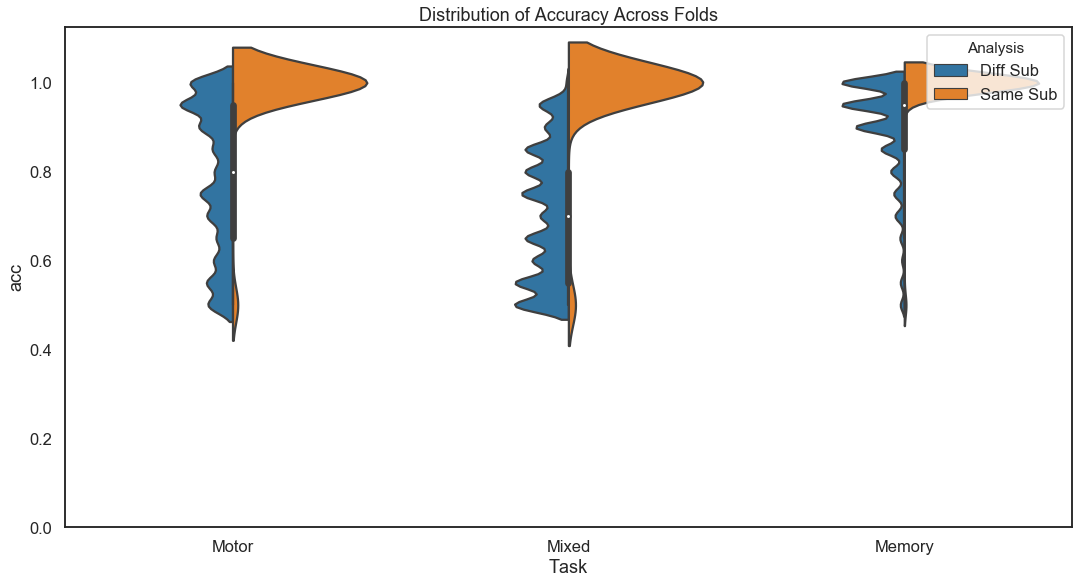

In [80]:
#distribution of accuracy between folds DS vs CV
sns.set_context('talk')
plt.figure(figsize=(15,8))
g=sns.violinplot(x='task', y='acc', hue='Analysis', data=sameTask, split=True)
g.set_xlabel('Task')
g.set(ylim=(0))
g.set_title('Distribution of Accuracy Across Folds')
plt.savefig(thisDir+'output/mL/images/ridge/figs/violin_plots.png', bbox_inches='tight')

subject by subject heatmap


/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


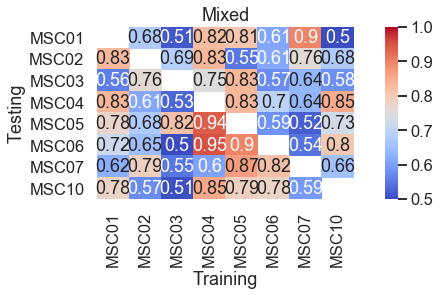

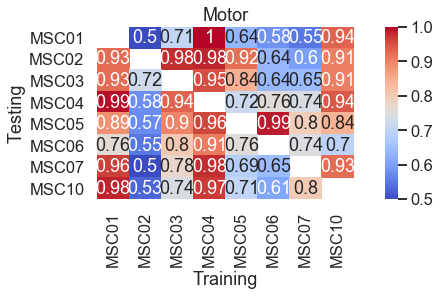

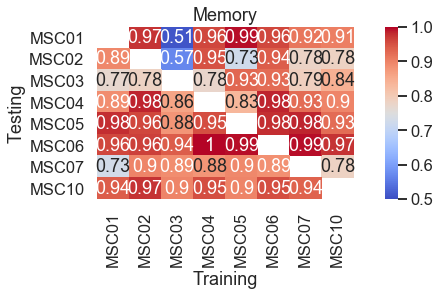

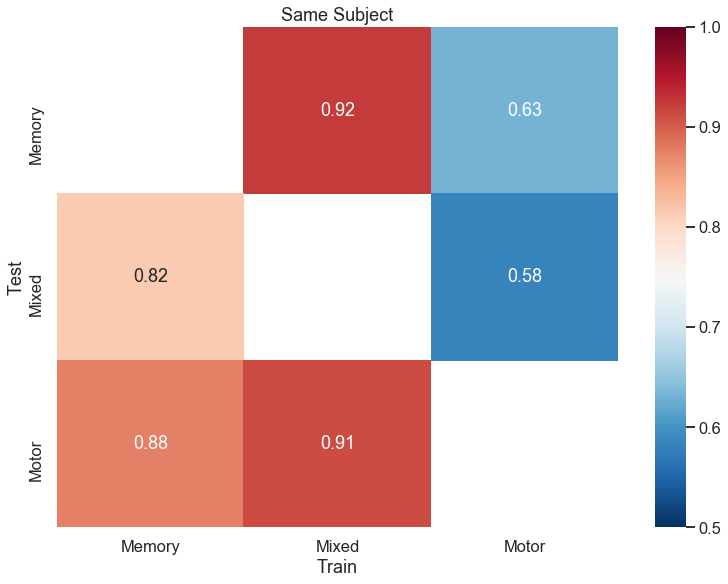

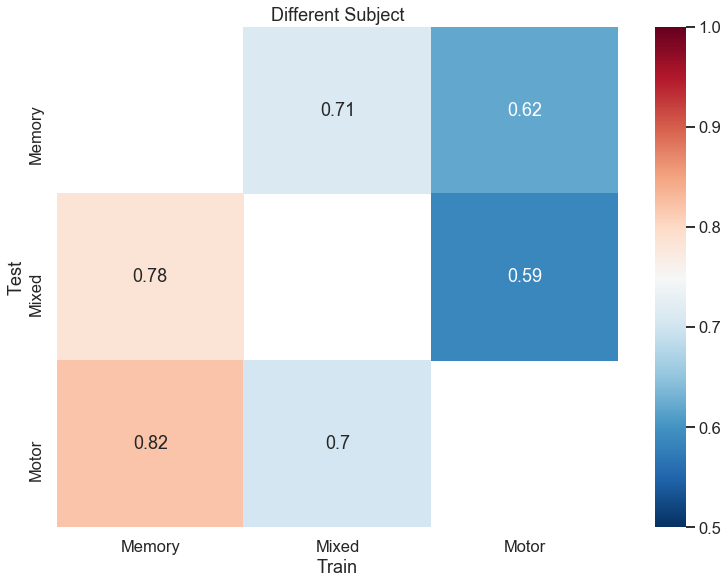

In [81]:
#maybe edit this later to include all code so saved all in figs file
#figure of heatmaps across subjects
results.plotACC(DS_heat, 'ridge', 'DS')
#heatmaps comparison of BS v SS
results.heatmaps('ridge', 'SS')
results.heatmaps('ridge', 'BS')

/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called Gri

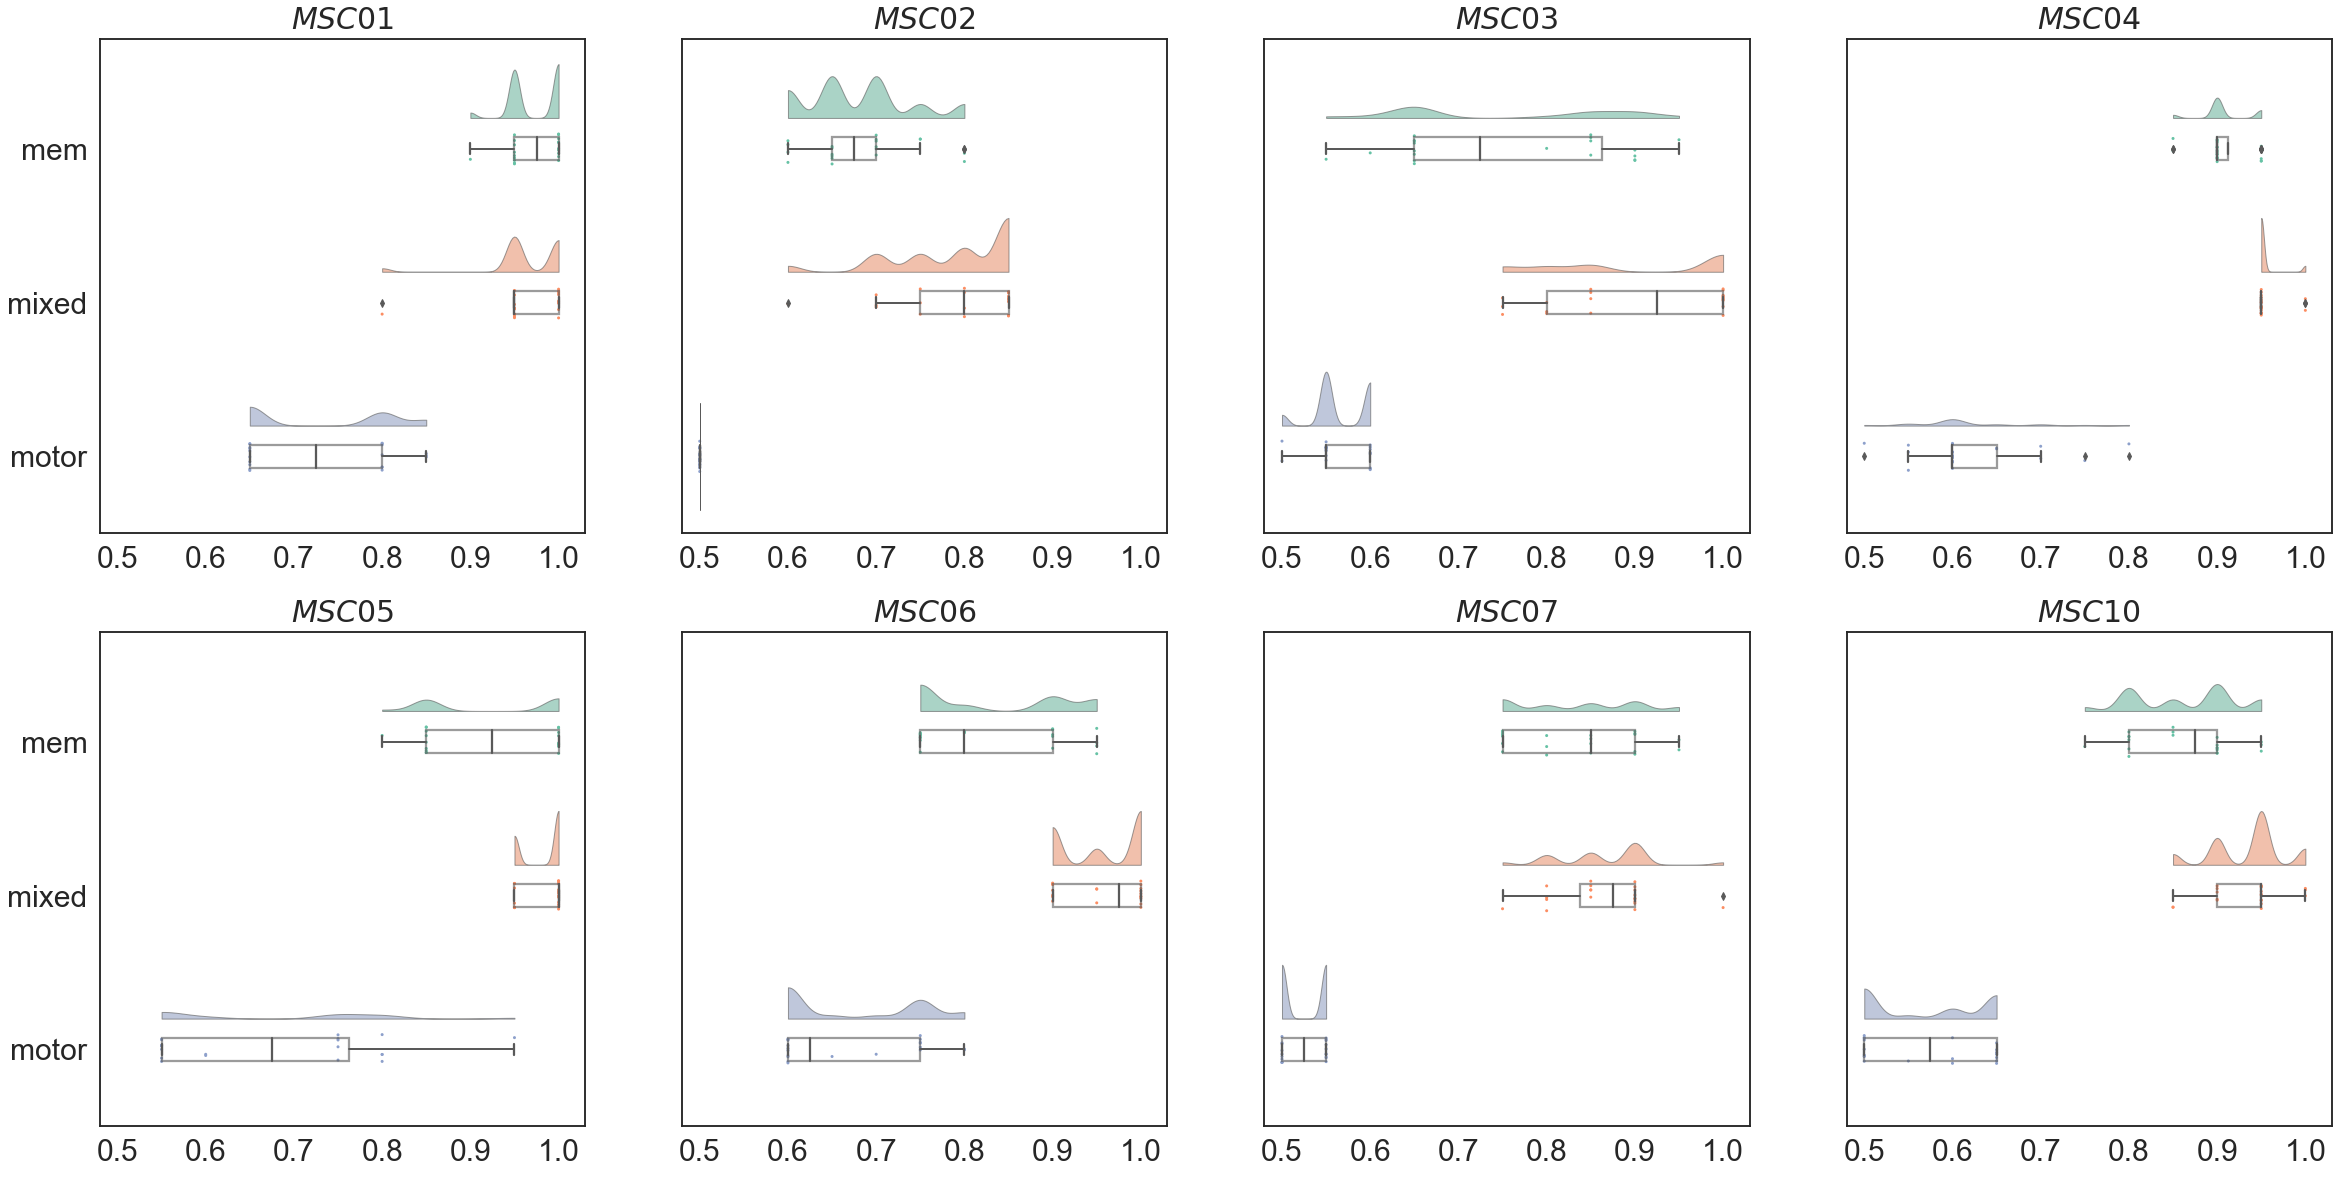

In [82]:
#Create figure space
fig=plt.figure(figsize=(40,20), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 2 rows by 4 columns
gs = gridspec.GridSpec(nrows=2, ncols=4)
#gs = gridspec.GridSpec(nrows=4, ncols=2)
#MSC01
ax1=fig.add_subplot(gs[0,0])
dx='train'; dy='MSC01'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax1)
ax.tick_params(labelsize=30)
ax.set_title('$MSC01$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC02
ax2=fig.add_subplot(gs[0,1], sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
dx='train'; dy='MSC02'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax2)
ax.tick_params(labelsize=30)
ax.set_title('$MSC02$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC03
ax3=fig.add_subplot(gs[0,2], sharey=ax1)
#ax3=fig.add_subplot(gs[1,0], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
dx='train'; dy='MSC03'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax3)
ax.tick_params(labelsize=30)
ax.set_title('$MSC03$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC04
ax4=fig.add_subplot(gs[0,3], sharey=ax1)
#ax4=fig.add_subplot(gs[1,1], sharey=ax1)
plt.setp(ax4.get_yticklabels(), visible=False)
dx='train'; dy='MSC04'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax4)
ax.tick_params(labelsize=30)
ax.set_title('$MSC04$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)


#MSC05
ax5=fig.add_subplot(gs[1,0])
#ax5=fig.add_subplot(gs[2,0])
dx='train'; dy='MSC05'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax5)
ax.tick_params(labelsize=30)
ax.set_title('$MSC05$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC06
ax6=fig.add_subplot(gs[1,1], sharey=ax5)
#ax6=fig.add_subplot(gs[2,1], sharey=ax5)
plt.setp(ax6.get_yticklabels(), visible=False)
dx='train'; dy='MSC06'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax6)
ax.tick_params(labelsize=30)
ax.set_title('$MSC06$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC07
ax7=fig.add_subplot(gs[1,2], sharey=ax5)
#ax7=fig.add_subplot(gs[3,0], sharey=ax5)
plt.setp(ax7.get_yticklabels(), visible=False)
dx='train'; dy='MSC07'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax7)
ax.tick_params(labelsize=30)
ax.set_title('$MSC07$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

#MSC10
ax8=fig.add_subplot(gs[1,3], sharey=ax5)
#ax8=fig.add_subplot(gs[3,1], sharey=ax5)
plt.setp(ax8.get_yticklabels(), visible=False)
dx='train'; dy='MSC10'; dhue='train'; ort='h'; pal='Set2'; sigma=.2
ax=pt.RainCloud(x=dx, y = dy, data = SS, bw = sigma,
                 width_viol = .7, alpha = .6, orient='h', dodge = True, ax=ax8)
ax.tick_params(labelsize=30)
ax.set_title('$MSC10$', fontsize=30, pad=10)
plt.ylabel('')
ax.set(xlabel=' ')
ax.set(xlim=(.48, 1.03))
x=[.5,.6,.7,.8,.9,1.0]
plt.xticks(x)

plt.savefig(thisDir+'output/mL/images/ridge/figs/raincloud_plots.png', bbox_inches='tight')

No handles with labels found to put in legend.
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  warnings.warn("Calling figure.constrained_layout, but figure not "
/Applications/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2314: UserWarning: Calling figure.constrained_layout, but figure not setup t

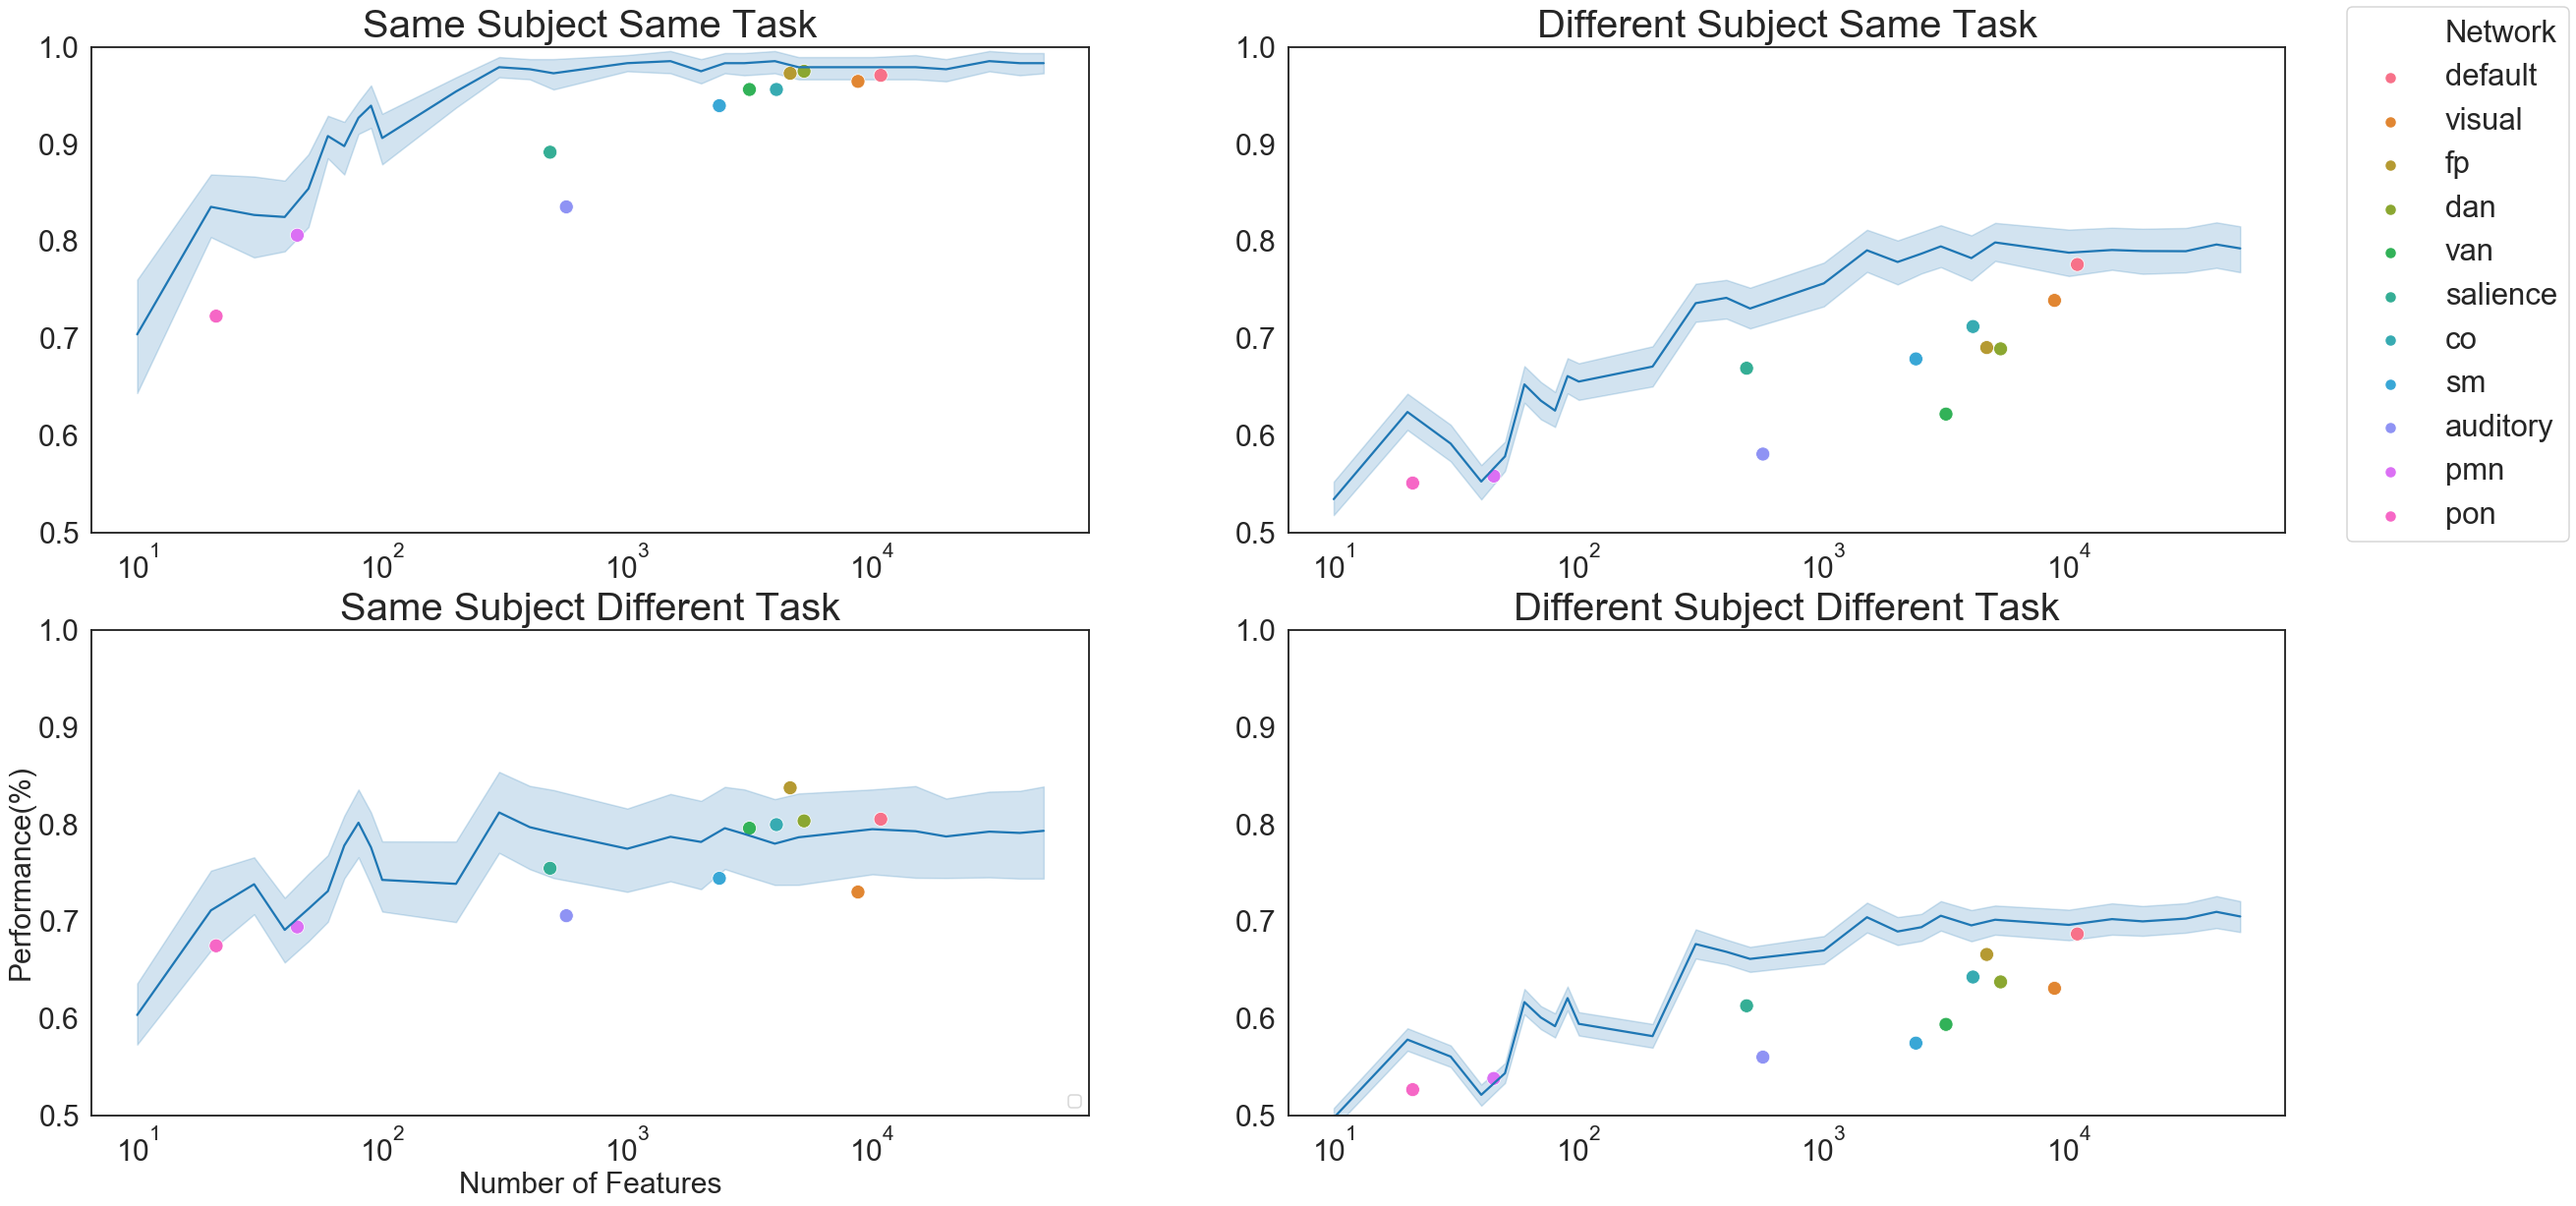

In [86]:
#lineplots overlapping subnetwork analysis
#Create figure space
fig=plt.figure(figsize=(40,20), constrained_layout=True)
plt.rcParams['figure.constrained_layout.use'] = True
#Add grid space for subplots 2 rows by 2 columns
gs = gridspec.GridSpec(nrows=2, ncols=2)

#CV
ax1=fig.add_subplot(gs[0,0])
ax = sns.lineplot(x="Features", y="Accuracy",data=rand_CV, ax=ax1)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=CV_mu, ax=ax1, color='r',s=200,legend=False)
#g.legend(loc='lower right')
ax.set_title('Same Subject Same Task',fontsize=40, pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)

#DS
ax2=fig.add_subplot(gs[0,1])
ax = sns.lineplot(x="Features", y="acc",data=rand_DS, ax=ax2)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=DS_mu, ax=ax2, color='r',s=200)
g.legend(loc='lower right')
ax.set_title('Different Subject Same Task',fontsize=40, pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)
plt.legend(bbox_to_anchor=(1.3, -0.05),loc='lower right',fontsize='xx-large')

#SS
ax3=fig.add_subplot(gs[1,0])
ax = sns.lineplot(x="Features", y="acc",data=rand_SS, ax=ax3)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=SS_mu, ax=ax3, color='r',s=200,legend=False)
g.legend(loc='lower right')
ax.set_title('Same Subject Different Task',fontsize=40, pad=10)
ax.set_ylabel("Performance(%)", fontsize=30)
ax.set_xlabel('Number of Features',fontsize=30)
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)

#BS
ax4=fig.add_subplot(gs[1,1])
ax = sns.lineplot(x="Features", y="acc",data=rand_BS, ax=ax4)
ax.set(xscale="log")
g=sns.scatterplot(x='Features', y='Acc', hue='Network', data=BS_mu, ax=ax4, color='r',s=200,legend=False)
ax.set_title('Different Subject Different Task',fontsize=40, pad=10)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set(ylim=(.5, 1))
ax.tick_params(labelsize=30)
#fig.text(0.075, 0.5, "Performance(%)", rotation="vertical", va="center", fontsize="30")
#fig.text(0.45, 0.07, 'Number of Features', rotation="horizontal", va="center", fontsize="30")

plt.savefig(thisDir+'output/mL/images/ridge/figs/feature_plots.png', bbox_inches='tight')